# SCI ANALYSIS - Data preparation

This notebook is part of my Master Thesis :  **Bayesian Inference for Geospatial Network Models of Large-scale Social Networks**. It includes all step I use for the SCI v distance and IO analysis and evaluation algorithms from it.

## Imports

In [ ]:
! pip install statsmodels

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.optimize import curve_fit
import statsmodels.api as sm
from tqdm import tqdm
from itertools import  product
from sklearn.neighbors import NearestNeighbors
from statsmodels.stats.diagnostic import het_breuschpagan
import scipy.stats as stats



# supress numpy runtime overflow warnings for 1/(1+np.exp(x)) when x large, as it "correctly" evaluates to 0

from numpy.testing import suppress_warnings


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Helper Functions

In [ ]:

@suppress_warnings() # use the suppress_warnings decorator

#### compute blau specific rank distances ###
#### save rank distances and rank distances for selected region pairs only: intra+4nn, intra+40nn, all ###
# version with minus option
def fuzzy_kotsubo_exp_row(pop,dist,nu, k = 10, minus = False, nu_minus = 5, delta = np.log(2)):
    with suppress_warnings() as sup:
        sup.filter(RuntimeWarning, "overflow encountered in exp")
        n = len(pop)
        #print("n : ", n)
        idx_sort = np.argsort(dist)
        #print("idx : ", idx_sort[:5])
        rev_idx_sort = np.argsort(idx_sort)
        #print("rev_idx : ", rev_idx_sort[:5])

        z = np.array(pop)[idx_sort]
        v = np.array(dist)[idx_sort]
        #print("z : ", z[:5])
        #print("v : ", v[:5])

        if not minus:

            Z = np.zeros((k,n))
            V= np.zeros((k,n))
            W_01 = np.zeros((k,n))

            for i in range(1,k+1):
                Z[i-1,:n-i] = z[i:]
                V[i-1,:n-i] = v[i:]
                W_01[i-1,:n-i] = 1

            #print('Z : ', Z[:5,:5])
            #print('V : ', V[:5,:5])

            W = W_01*np.exp( -(1/nu)*np.log(2)*(np.abs(V - v[None,:])))  # absolute value is only for computational purposes, as it evaluates the term inside exp() to a negative value when V = 0 (there are cases with weight W_01 = 0)
            #print("W_01", W_01[:3,:3])
            #print("W", W[:3,:3])

            y = (W*Z).sum(axis = 0) +  np.cumsum(z)
            #print("left : ", np.mean((W*Z).sum(axis = 0)), "right : ", np.mean(np.cumsum(z)))
            #print("y", y[:5])
            return y[rev_idx_sort]

        if minus:
            Z = np.zeros((2*k,n))
            V= np.ones((2*k,n))
            W_01 = np.zeros((2*k,n))
            for i in range(1,k+1):
                #minus
                Z[i-1,i:] = z[:n-i]
                V[i-1,i:] = v[:n-i]
                W_01[i-1,i:] = -1 ###!!! substract some mass of the IOs at smaller distance

                #plus
                Z[i+k-1,:n-i] = z[i:]
                V[i+k-1,:n-i] = v[i:]
                W_01[i+k-1,:n-i] = 1
            W = W_01*np.exp( -np.repeat([delta,0],k)[:,None] -np.repeat([1/nu, 1/nu_minus], k )[:,None]*np.log(2)*np.abs(V - v[None,:]) )
            y = (W*Z).sum(axis = 0) + np.cumsum(z)
            return y[rev_idx_sort]

def get_fuzzy_kotsubo_exp(pop,dist,nu = 5, print_rows = False, k = 10, nu_minus = 5, delta = np.log(2), minus = False):
    pop_dist = np.zeros(dist.shape)
    for i,r in enumerate(dist.index):
        #print(f"Index : {i} , Region : {r}")
        pop_dist[i] = fuzzy_kotsubo_exp_row(pop, dist.loc[r], nu = nu, k = k, nu_minus = nu_minus, delta = delta, minus = minus)
        if print_rows:
            if i%100 == 0:
                print(i)
    pop_dist = pd.DataFrame(pop_dist, index = dist.index, columns = dist.columns)
    return pop_dist


def get_row_col_pairs_from_df(df,pairs):
    if '_' not in pairs[0]:
        if type(pairs[0]) != list:
            raise ValueError('wrong type')
        index = [ i[0]+'_'+i[1] for i in pairs]
        rows, cols = np.array(pairs).T
        row_idx = df.index.get_indexer(rows)
        col_idx = df.columns.get_indexer(cols)
        values = df.to_numpy()[row_idx, col_idx]
        values = pd.Series(values, index = index)
        return(values)
    elif '_to_' in pairs[0]:
        index = pairs
        row_col_pairs = [p.split('_to_') for p in pairs]
        rows, cols = np.array(row_col_pairs).T
        row_idx = df.index.get_indexer(rows)
        col_idx = df.columns.get_indexer(cols)
        values = df.to_numpy()[row_idx, col_idx]
        values = pd.Series(values, index = index)
        return(values)
    elif '_' in pairs[0]:
        index = pairs
        row_col_pairs = [p.split('_') for p in pairs]
        rows, cols = np.array(row_col_pairs).T
        row_idx = df.index.get_indexer(rows)
        col_idx = df.columns.get_indexer(cols)
        values = df.to_numpy()[row_idx, col_idx]
        values = pd.Series(values, index = index)
        return(values)
    else:
        return ValueError('wrong input')


def compute_blau_specific_rank_dist(blau_df, euc_dist, pairs_dict, nu = 4, k = 15):
    cats = list( blau_df.columns )
    # N_cats = len(cats)
    rank_dist_dict = {}
    for name, pairs in pairs_dict.items():
        rank_dist_dict[name] = pd.DataFrame(index = pairs)
    for c, cat in enumerate(cats):
        rank_dist_non_sym = get_fuzzy_kotsubo_exp(blau_df.iloc[:,c], euc_dist, nu = nu, k = k, minus = False)
        rank_dist_geo = (rank_dist_non_sym * rank_dist_non_sym.T)**0.5
        for name, pairs in pairs_dict.items():
            rank_dist_dict[name][cat] = get_row_col_pairs_from_df(rank_dist_geo, pairs)
    return rank_dist_dict


In [ ]:
max_eval = 10000



@suppress_warnings()

### data ###
# pop is 1d array of populations per NUTS3 region (e.g. pandas Series)
# dist is symmetric 2d array of distances between NUTS3 regions (e.g. pandas DataFrame), where dist[i,j] is the distance between region i and region j -- the rows of dist should correspond to the rows of pop (same ordering)
# SCI is symmetric 2d array of social connectivity between NUTS3 regions (e.g. pandas DataFrame), ordering should correspond to dist
# y is one dimensional array of SCI values (e.g., the if SCI is a 2d array then y = np.diag(SCI) or y = SCI[np.tril_indices(SCI.shape[0])] or sth similar)
# x = np.log(1/r), where r is one dimensional array of intervening opportunities corresponiing to the region pairs in y
# sigma = 1/r (or 1/x??, not sure what is better) is the scale (up to a constant factor) of the standard deviation of the errors in y as a function of x


# helper function for generating the design matrix X for the quadratic spline model
def get_X_quad_helper(z, knots, add_const = True):
    """
    z is empirical data, must be ordered form smallest to largest
    knots are the indizes corresponding to the knots of the spline model
    knots[0] must be 0
    knots[-1] must be equal to len(z)-1
    """
    z = np.array(z)
    knots = np.array(knots)
    N = len(z)
    N_knots = len(knots)
    knots_len = knots[1:] - knots[:-1]
    knots_len[-1] = knots_len[-1] + 1
    X = np.ones(N).reshape(-1,1)
    #linear_term = np.zeros(N)
    #linear_term[1:] = np.cum_sum

    if knots_len[0] >=1:
        #X = np.hstack([X,np.arange(N).reshape(-1,1)])
        X = np.hstack([X, z.reshape(-1,1) ])
    for k, knot_l in enumerate(knots_len):
        if k == N_knots - 1:
            knot_l = knot_l - 1

        X_new = np.zeros(N)

        z_new = z[knots[k]:knots[k+1]+1] - z[knots[k]]
        z_new_max = z_new[-1]

        z_new_rest = z[knots[k+1]+1 : ] - z[knots[k+1]]

        X_new[np.sum(knots_len[:k]):np.sum(knots_len[:k+1])+1] = np.array( [ 0.5*y**2 for y in z_new ] )

        X_new[np.sum(knots_len[:k+1])+1 : ] = np.array( [ 0.5*z_new_max**2 + y*z_new_max for y in z_new_rest] )

        #print('k,X_new',k,X_new)

        X = np.hstack([X,X_new.reshape(-1,1)])
        #print('X',X)

    if not add_const:
        X = X[:,1:]

    return(X)

# This function generates the design matrix X for the quadratic spline model
def get_X(x,knots, add_const = False):
    x = np.clip(x, 1e-10, None)
    n = len(x)
    idx_sort = np.argsort(x)
    rev_idx_sort = np.argsort(idx_sort)
    y = x[idx_sort]
    y = np.log(y)
    y = y - np.min(y)
    X = get_X_quad_helper(y,knots, add_const = add_const)
    X = X[rev_idx_sort]
    return X


# generlaized logistic function
def gen_log(x,K,Q,B0,mu):
    val = K / (1 + Q*np.exp( B0*x))**mu
    return val

# Optimized curve fitting function
def eval_curve_fit(x,y, p_init = None, sigma = None, f = gen_log ,bounds = ([0, 0, 0, 0],np.inf),max_eval = max_eval):
    if not p_init:
        p_init = [y.max(),1,0.5,1]

    try:
        popt, pcov = curve_fit(f, xdata = x, ydata = y, p0 = p_init, bounds = bounds, max_nfev = max_eval, sigma  = sigma)
        r = (y - f(x,*popt))
        mse = np.sum( (r/sigma)**2 ) / (len(y) - 4)
        return (True, popt, mse,r)
    except:
        return (False, False, False)

## Load and Prepare datas : SCI, POP, DIST

In [ ]:
def load_and_prepare_data(distance_path, pop_path, sci_path, area_path):
    # Load datasets
    distance = pd.read_csv(distance_path, sep=';', index_col=0) / 1e3
    pop = pd.read_csv(pop_path)
    SCI = pd.read_csv(sci_path, sep='\t')
    area = pd.read_csv(area_path)
    area = area.drop(columns=['DATAFLOW', 'LAST UPDATE', 'freq', 'landuse', 'unit', 'TIME_PERIOD', 'OBS_FLAG', 'CONF_STATUS'])
    area = area.rename(columns={"geo": "GEO", "OBS_VALUE": "VALUE"})
    area.set_index('GEO', inplace=True)

    # Preprocess population
    pop.loc[pop['AGE'] == 'Y1529', 'VALUE'] *= 17 / 15
    pop = pop.groupby('REGION').sum()['VALUE']
    pop = pop[~pop.index.str.startswith('UK')]

    # Intersection
    valid_regions = sorted(list(pop.index.intersection(distance.index).intersection(area.index)))

    # Filter everything
    SCI = SCI[SCI['user_loc'].isin(valid_regions) & SCI['fr_loc'].isin(valid_regions)]
    distance = distance.loc[valid_regions, valid_regions]
    pop = pop.loc[valid_regions]
    area = area.loc[valid_regions]

    # Matrix SCI
    SCI_matrix = SCI.pivot(index='user_loc', columns='fr_loc', values='scaled_sci')
    all_regions = sorted(valid_regions)
    SCI_matrix = SCI_matrix.reindex(index=all_regions, columns=all_regions, fill_value=0)
    # Intra-regional distances
    radius = np.sqrt(area['VALUE'] / np.pi)
    intra_distance = (2 / 3) * radius
    np.fill_diagonal(distance.values, intra_distance.loc[distance.index].values)

    # Normalize SCI
    n = pop.values.reshape(-1, 1)
    SCI_np = SCI_matrix.values
    SCI_proj = (n.T @ SCI_np @ n) / n.sum()
    c = SCI_proj / 150
    SCI_hat = SCI_np / c
    SCI_hat_matrix = pd.DataFrame(SCI_hat, index=SCI_matrix.index, columns=SCI_matrix.columns)

    pop = pop.astype('float32') / 1e3
    distance = distance.astype('float32')
    area = area.astype('float32')
    SCI_matrix = SCI_matrix.astype('float32')
    SCI_hat_matrix = SCI_hat_matrix.astype('float32')

    return pop, distance, area, SCI_matrix, SCI_hat_matrix

In [ ]:
distance_path = '/content/drive/MyDrive/RESEARCH/distance_nuts3.csv'
pop_path = '/content/drive/MyDrive/RESEARCH/result.csv'
SCI_path = "/content/drive/MyDrive/RESEARCH/gadm1_nuts3_counties-gadm1_nuts3_counties - FB Social Connectedness Index - October 2021.tsv"
area_path = "/content/drive/MyDrive/RESEARCH/area_nuts3.csv"

pop, distance, area, SCI_matrix, SCI_hat_matrix = load_and_prepare_data(
        distance_path, pop_path, SCI_path, area_path
    )

## EDA

In [ ]:
sci_values = SCI_matrix.values[np.tril_indices_from(SCI_matrix, k=0)]
sci_values = sci_values[~np.isnan(sci_values)]

print("Nombre total de paires :", len(sci_values))
print("Min :", sci_values.min())
print("Max :", sci_values.max())
print("Médiane :", np.median(sci_values))
print("Mean : ", np.mean(sci_values))

Nombre total de paires : 807085
Min : 1.0
Max : 172696300.0
Médiane : 233.0
Mean :  12474.519


In [ ]:
num_ones = np.sum(sci_values == 1)
print(f"{num_ones} pairs with no links (SCI = 1)")


275 pairs with no links (SCI = 1)


In [ ]:
sci_values = SCI_hat_matrix.values[np.tril_indices_from(SCI_hat_matrix, k=0)]
sci_values = sci_values[~np.isnan(sci_values)]

print("Nombre total de paires :", len(sci_values))
print("Min :", sci_values.min())
print("Max :", sci_values.max())
print("Médiane :", np.median(sci_values))
print("Mean : ", np.mean(sci_values))

Nombre total de paires : 807085
Min : 8.894012e-11
Max : 0.01535963
Médiane : 2.0723048e-08
Mean :  1.1094852e-06


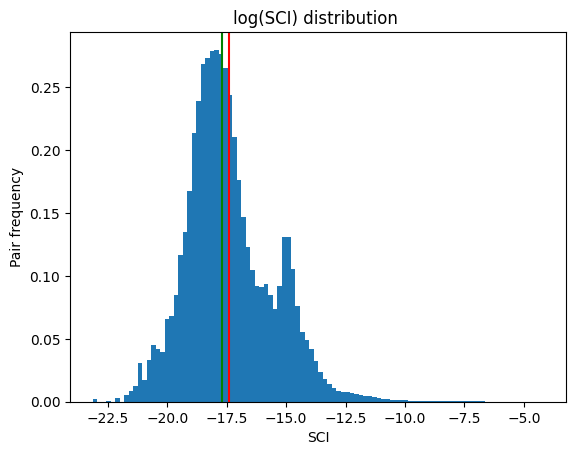

In [ ]:
plt.hist(np.log(sci_values), bins = 100,density = True)
plt.axvline(np.mean(np.log(sci_values)), color = 'r')
plt.axvline(np.median(np.log(sci_values)), color = 'g')
plt.title("log(SCI) distribution ")
plt.xlabel("SCI")
plt.ylabel("Pair frequency")
plt.show()


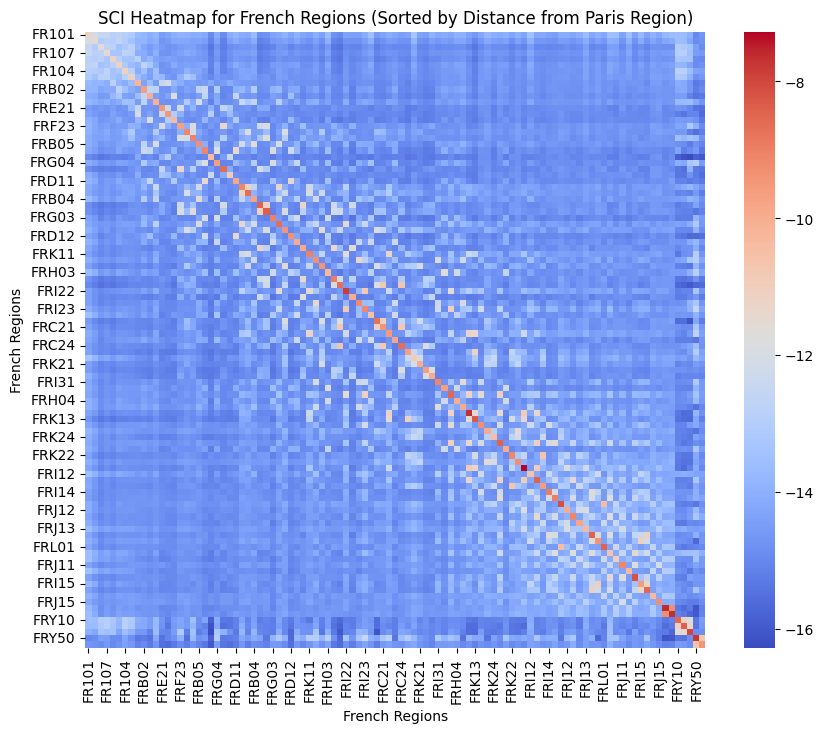

In [ ]:
# Filter for French regions
france_regions = [col for col in SCI_hat_matrix.columns if col.startswith('FR')]
sci_france = SCI_hat_matrix.loc[france_regions, france_regions]
sci_france = np.log(sci_france)
# Get distances from a reference French region (e.g., the first one) and sort regions
reference_region = france_regions[0]
distances_from_ref = distance.loc[france_regions, reference_region].sort_values()
sorted_france_regions = distances_from_ref.index.tolist()

# Reindex the SCI matrix for France based on sorted distances
sci_france_sorted = sci_france.reindex(index=sorted_france_regions, columns=sorted_france_regions)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sci_france_sorted, cmap='coolwarm', annot=False)
plt.title('SCI Heatmap for French Regions (Sorted by Distance from Paris Region)')
plt.xlabel('French Regions')
plt.ylabel('French Regions')
plt.show()

<Figure size 800x800 with 0 Axes>

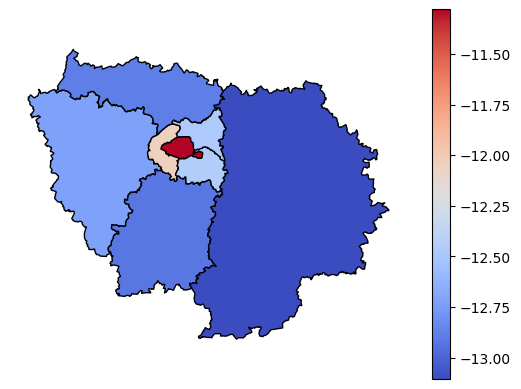

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Charger shapefile NUTS3 (par ex. depuis Eurostat, ici supposons qu'il est téléchargé)
url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/shp/NUTS_RG_01M_2021_4326.shp.zip"
gdf = gpd.read_file(url)

# Filtrer Ile-de-France (NUTS2 = FR10) ou NUTS3 départements qui commencent par "FR1"
idf_gdf = gdf[gdf['NUTS_ID'].str.startswith("FR1")]

# Exemple : somme des flux depuis la région de référence (Paris = reference_region)
flows_from_ref = sci_france.loc[reference_region]  # flux vers toutes les autres régions
flows_from_ref = flows_from_ref.reset_index()
flows_from_ref.columns = ['NUTS_ID', 'SCI_value']

# Merger flux avec géométries
idf_gdf = idf_gdf.merge(flows_from_ref, on="NUTS_ID")

# Plot
plt.figure(figsize=(8,8))
idf_gdf.plot(column="SCI_value", cmap="coolwarm", legend=True, edgecolor="black")
plt.axis("off")
plt.show()


<Figure size 1000x1000 with 0 Axes>

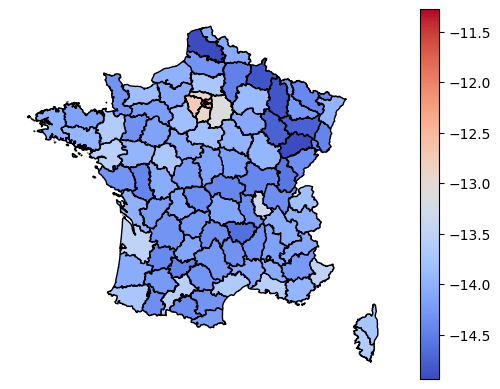

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Shapefile Eurostat NUTS 2021 (EPSG:4326)
url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/shp/NUTS_RG_01M_2021_4326.shp.zip"
gdf = gpd.read_file(url)

# France métropolitaine seulement (NUTS 3)
france_gdf = gdf[
    (gdf['NUTS_ID'].str.startswith("FR")) &
    (gdf['LEVL_CODE']==3) &
    (~gdf['NUTS_ID'].str.startswith("FRY"))
]

# Référence = Paris (département)
reference_region = "FR101"

# Flux depuis Paris vers tous les départements
flows_from_ref = sci_france.loc[reference_region].reset_index()
flows_from_ref.columns = ['NUTS_ID', 'SCI_value']

# Merge avec la géométrie des départements métropolitains
france_gdf = france_gdf.merge(flows_from_ref, on="NUTS_ID", how="left")
france_gdf['SCI_value'] = france_gdf['SCI_value'].fillna(0)

# Plot
plt.figure(figsize=(10,10))
france_gdf.plot(column="SCI_value", cmap="coolwarm", legend=True, edgecolor="black")
plt.axis("off")
plt.show()


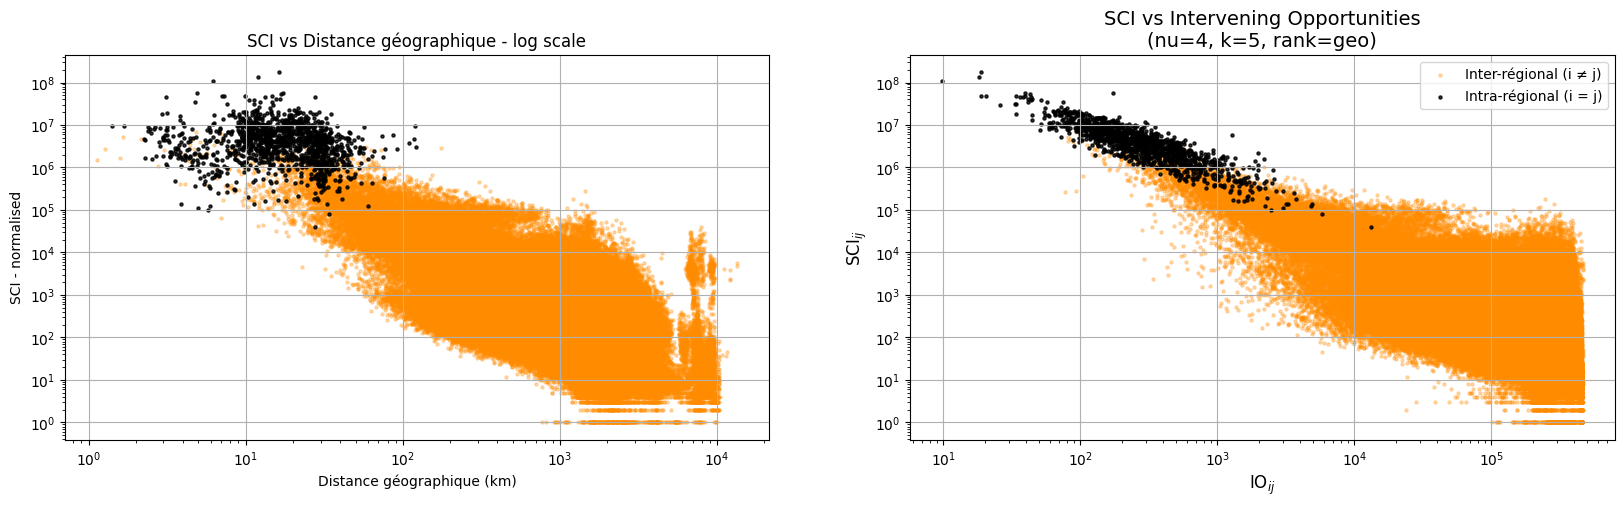

In [ ]:
nu = 4
k = 5

fig, ax = plt.subplots(1,2, figsize =(20,5))
valid_regions = sorted(list(pop.index.intersection(distance.index).intersection(area.index)))
dist_aligned = distance.loc[valid_regions, valid_regions]

sci_values = SCI_matrix.values[np.tril_indices_from(SCI_matrix, k=0)]
sci_values = sci_values[~np.isnan(sci_values)]
dist_vals = dist_aligned.values[np.tril_indices_from(dist_aligned, k=0)]

rd = get_fuzzy_kotsubo_exp(pop.values, distance, nu=nu, k=k, minus=False)
rd_geo = np.sqrt(rd * rd.T)

rd_geo_flat = rd_geo.values[np.tril_indices_from(rd_geo, k=0)]

# Identifie les indices i, j correspondants aux paires (i,j) dans la triangle inférieure
i_idx, j_idx = np.tril_indices_from(SCI_matrix, k=0)

valid = (~np.isnan(sci_values))
x_d = dist_vals[valid]
y_d = sci_values[valid]
# Filtre : validité des données

x = rd_geo_flat[valid]
y = sci_values[valid]
same_region = (i_idx[valid] == j_idx[valid])  # Booléen : True si i == j

#distance
ax[0].scatter(x_d[~same_region], y_d[~same_region], color='darkorange', alpha=0.3, s=5, label='Inter-régional (i ≠ j)')
ax[0].scatter(x_d[same_region], y_d[same_region], color='black', alpha=0.8, s=5, label='Intra-régional (i = j)')


ax[0].set_xlabel("Distance géographique (km)")
ax[0].set_ylabel("SCI - normalised")
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_title("SCI vs Distance géographique - log scale")
ax[0].grid(True)

# Tracé avec code couleur
ax[1].scatter(x[~same_region], y[~same_region], color='darkorange', alpha=0.3, s=5, label='Inter-régional (i ≠ j)')
ax[1].scatter(x[same_region], y[same_region], color='black', alpha=0.8, s=5, label='Intra-régional (i = j)')

ax[1].set_xlabel("IO$_{ij}$", fontsize=12)
ax[1].set_ylabel("SCI$_{ij}$", fontsize=12)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_title(f"SCI vs Intervening Opportunities\n(nu={nu}, k={k}, rank=geo)", fontsize=14)
ax[1].grid(True)
ax[1].legend()

plt.show()


## MSE

In [ ]:
# Valid region check
valid_regions = sorted(list(set(pop.index) & set(distance.index) & set(area.index)))
print(f"Nombre de régions valides : {len(valid_regions)}")

pop = pop.loc[valid_regions]
area = area.loc[valid_regions]
distance = distance.loc[valid_regions, valid_regions]


Nombre de régions valides : 1270


In [ ]:
regions = list(distance.index)

# Intra-region pairs
intra_pairs = [f'{r}_{r}' for r in regions]

# 4 nearest neighbors
nbrs = NearestNeighbors(n_neighbors=5, metric='precomputed').fit(distance)
_, indices = nbrs.kneighbors(distance)
pairs_4nn = []
for i, neighbors in enumerate(indices):
    for j in neighbors:  # exclude self
        pairs_4nn.append(f'{regions[i]}_{regions[j]}')

# 40 nearest neighbors
nbrs = NearestNeighbors(n_neighbors=41, metric='precomputed').fit(distance)
_, indices = nbrs.kneighbors(distance)
pairs_40nn = []
for i, neighbors in enumerate(indices):
    for j in neighbors:  # exclude self
        pairs_40nn.append(f'{regions[i]}_{regions[j]}')

# All lower triangle pairs
all_pairs = [f'{r1}_{r2}' for i, r1 in enumerate(regions) for r2 in regions[i:]]

pairs_dict = {
    'intra': intra_pairs,
    '4nn': pairs_4nn,
    '40nn': pairs_40nn,
    'all': all_pairs
}


In [ ]:
Y_values = {}
for pair_group, pairs in tqdm(pairs_dict.items()):
    y = get_row_col_pairs_from_df(SCI_hat_matrix, pairs).values
    Y_values[pair_group] = y


100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


In [ ]:
nu_list = [5,4,3,2,1]
k_list = [0,1,5,10, 15, 20]


row_index = pd.MultiIndex.from_product([['nu=%i'%nu for nu in nu_list], ['k=%i'%k for k in k_list]])
col_index = pd.MultiIndex.from_product([['intra', '4nn', '40nn', 'all'], ['geo']]) # ['ari', 'geo', 'har']

df_ols_mse = pd.DataFrame(index=row_index, columns=col_index)
df_logistic_mse = pd.DataFrame(index=row_index, columns=col_index)
df_logistic_mse_squared = pd.DataFrame(index=row_index, columns=col_index)

for i_nu,i_k in tqdm(product(range(len(nu_list)),range(len(k_list))),"Perform MSE : ", total = len(nu_list) * len(k_list)):
        nu, k = nu_list[i_nu], k_list[i_k]
        key = (f'nu={nu}', f'k={k}')

        rank_dist = get_fuzzy_kotsubo_exp(pop, distance, nu=nu, k=k, minus=False)

        rank_geo = (rank_dist * rank_dist.T)**0.5
        #rank_ari = 0.5 * (rank_dist + rank_dist.T)
        #rank_har = 2 / (1 / rank_dist + 1 / rank_dist.T)
        #print('IOS : ', rank_dist.iloc[:5,:5])  # ou un résidu entre IOs successifs

        rank_all = {
            'geo': rank_geo}
           # 'ari': rank_ari,
           # 'har': rank_har}
        for dist_name, dist_matrix in rank_all.items():
            for pair_group, pairs in pairs_dict.items():
                try:
                    x = get_row_col_pairs_from_df(dist_matrix, pairs).values
                    #print('Check len : ', len(x), x.min(), x.max())
                    y = Y_values[pair_group] #get_row_col_pairs_from_df(SCI_hat_matrix, pairs).values

                    # Nettoyage
                    #mask = (x > 0) & (y > 0)
                    #x = x[mask]
                    #y = y[mask]


                    if len(x) < 10:
                        continue
                    idx = np.argsort(x)
                    x_sorted = x[idx]
                    y_sorted = y[idx]

                    ## ---- Spline model ----
                    log_y = np.log(y_sorted)
                    sigma = 1 / x_sorted
                    #sigma2 = 1 / np.sqrt(x_sorted)
                    knots = np.round(np.linspace(0, len(x)-1, 10)).astype(int)
                    #knots = np.quantile(1 / x_sorted, np.linspace(0,1,11)[1:-1]).astype(int)
                    X = get_X(1 / x_sorted, knots, add_const=True)

                    model = sm.OLS(log_y, X, hasconst=True)
                    results = model.fit()
                    mse_ols = results.mse_resid
                    #print(f"MSE OLS ({key}, {pair_group}, {dist_name}): {mse_ols}")
                    df_ols_mse.loc[key, (pair_group, dist_name)] = mse_ols

                    # ---- Logistic model ----
                    xdata = np.log(x_sorted)
                    cond, popt, mse_logistic,_ = eval_curve_fit(xdata, y_sorted, sigma=sigma)
                    if cond:
                        df_logistic_mse.loc[key, (pair_group, dist_name)] = mse_logistic

                    ## ---- Logistic Squared model ----
                    #cond2, popt2, mse_logistic_sq = eval_curve_fit(xdata, y_sorted, sigma=sigma2)
                    #if cond2:
                    #    df_logistic_mse_squared.loc[key, (pair_group, dist_name)] = mse_logistic_sq

                except Exception as e:
                    print(f"Erreur ({key}, {pair_group}, {dist_name}) : {e}")
                    continue

display(df_ols_mse)
display(df_logistic_mse)

Perform MSE : 100%|██████████| 30/30 [36:16<00:00, 72.55s/it]


intra       4nn      40nn       all
                geo       geo       geo       geo
nu=5 k=0   0.319826  1.294403  2.106787  1.910034
     k=1   0.272338  1.213914  2.099635  1.909408
     k=5    0.25966  1.195582  2.100594  1.909802
     k=10   0.26124  1.205682  2.103589  1.911025
     k=15  0.262182  1.208765  2.104996  1.911947
     k=20  0.262495  1.209832  2.105629  1.912551
nu=4 k=0   0.319826  1.294403  2.106787  1.910034
     k=1   0.273008  1.213255  2.099054  1.909429
     k=5   0.256801   1.19106  2.098758  1.909918
     k=10  0.256016  1.195163  2.100462  1.911007
     k=15  0.256115  1.196204  2.101119   1.91171
     k=20  0.256135  1.196489  2.101354  1.912114
nu=3 k=0   0.319826  1.294403  2.106787  1.910034
     k=1   0.278484  1.217494  2.099029  1.909496
     k=5   0.265838  1.195851  2.098059  1.910089
     k=10  0.265004  1.196687  2.098798  1.910963
     k=15  0.264939  1.196867  2.099008   1.91141
     k=20  0.264927    1.1969  2.099064  1.911622
nu=2 k=0   0.319826  1.294403  2.106787  1.910034
     k=1   0.289554  1.229397  2.099903  1.909633
     k=5   0.283764  1.213517  2.098868  1.910275
     k=10  0.283583  1.213473  2.099056   1.91082
     k=15  0.283575  1.213476  2.099086  1.911007
     k=20  0.283574  1.213476   2.09909   1.91107
nu=1 k=0   0.319826  1.294403  2.106787  1.910034
     k=1   0.305491  1.252514  2.102135  1.909863
     k=5   0.304905  1.246063   2.10155  1.910338
     k=10  0.304904  1.246063  2.101541  1.910483
     k=15  0.304904  1.246062  2.101542  1.910503
     k=20  0.304904  1.246062  2.101542  1.910505

intra       4nn      40nn       all
                geo       geo       geo       geo
nu=5 k=0   0.002423  0.001134  0.000394  0.000828
     k=1   0.002643   0.00123  0.000424  0.000833
     k=5   0.003547  0.001478  0.000477  0.000843
     k=10  0.003599  0.001511  0.000484  0.000847
     k=15  0.003624  0.001522  0.000486  0.000848
     k=20  0.003629  0.001525  0.000486  0.000849
nu=4 k=0   0.002423  0.001134  0.000394  0.000828
     k=1   0.002478  0.001162  0.000413  0.000832
     k=5   0.002908  0.001268  0.000442  0.000839
     k=10  0.002909  0.001275  0.000445  0.000842
     k=15  0.002912  0.001277  0.000445  0.000843
     k=20  0.002912  0.001277  0.000445  0.000843
nu=3 k=0   0.002423  0.001134  0.000394  0.000828
     k=1   0.002386  0.001118  0.000405  0.000831
     k=5   0.002538  0.001143  0.000418  0.000836
     k=10  0.002534  0.001143  0.000419  0.000838
     k=15  0.002534  0.001143  0.000419  0.000838
     k=20  0.002534  0.001143  0.000419  0.000838
nu=2 k=0   0.002423  0.001134  0.000394  0.000828
     k=1   0.002362    0.0011  0.000399   0.00083
     k=5   0.002387  0.001093  0.000404  0.000833
     k=10  0.002387  0.001093  0.000404  0.000834
     k=15  0.002387  0.001093  0.000404  0.000834
     k=20  0.002387  0.001093  0.000404  0.000834
nu=1 k=0   0.002423  0.001134  0.000394  0.000828
     k=1   0.002386  0.001107  0.000396  0.000829
     k=5   0.002386  0.001101  0.000397  0.000831
     k=10  0.002386  0.001101  0.000397  0.000831
     k=15  0.002386  0.001101  0.000397  0.000831
     k=20  0.002386  0.001101  0.000397  0.000831

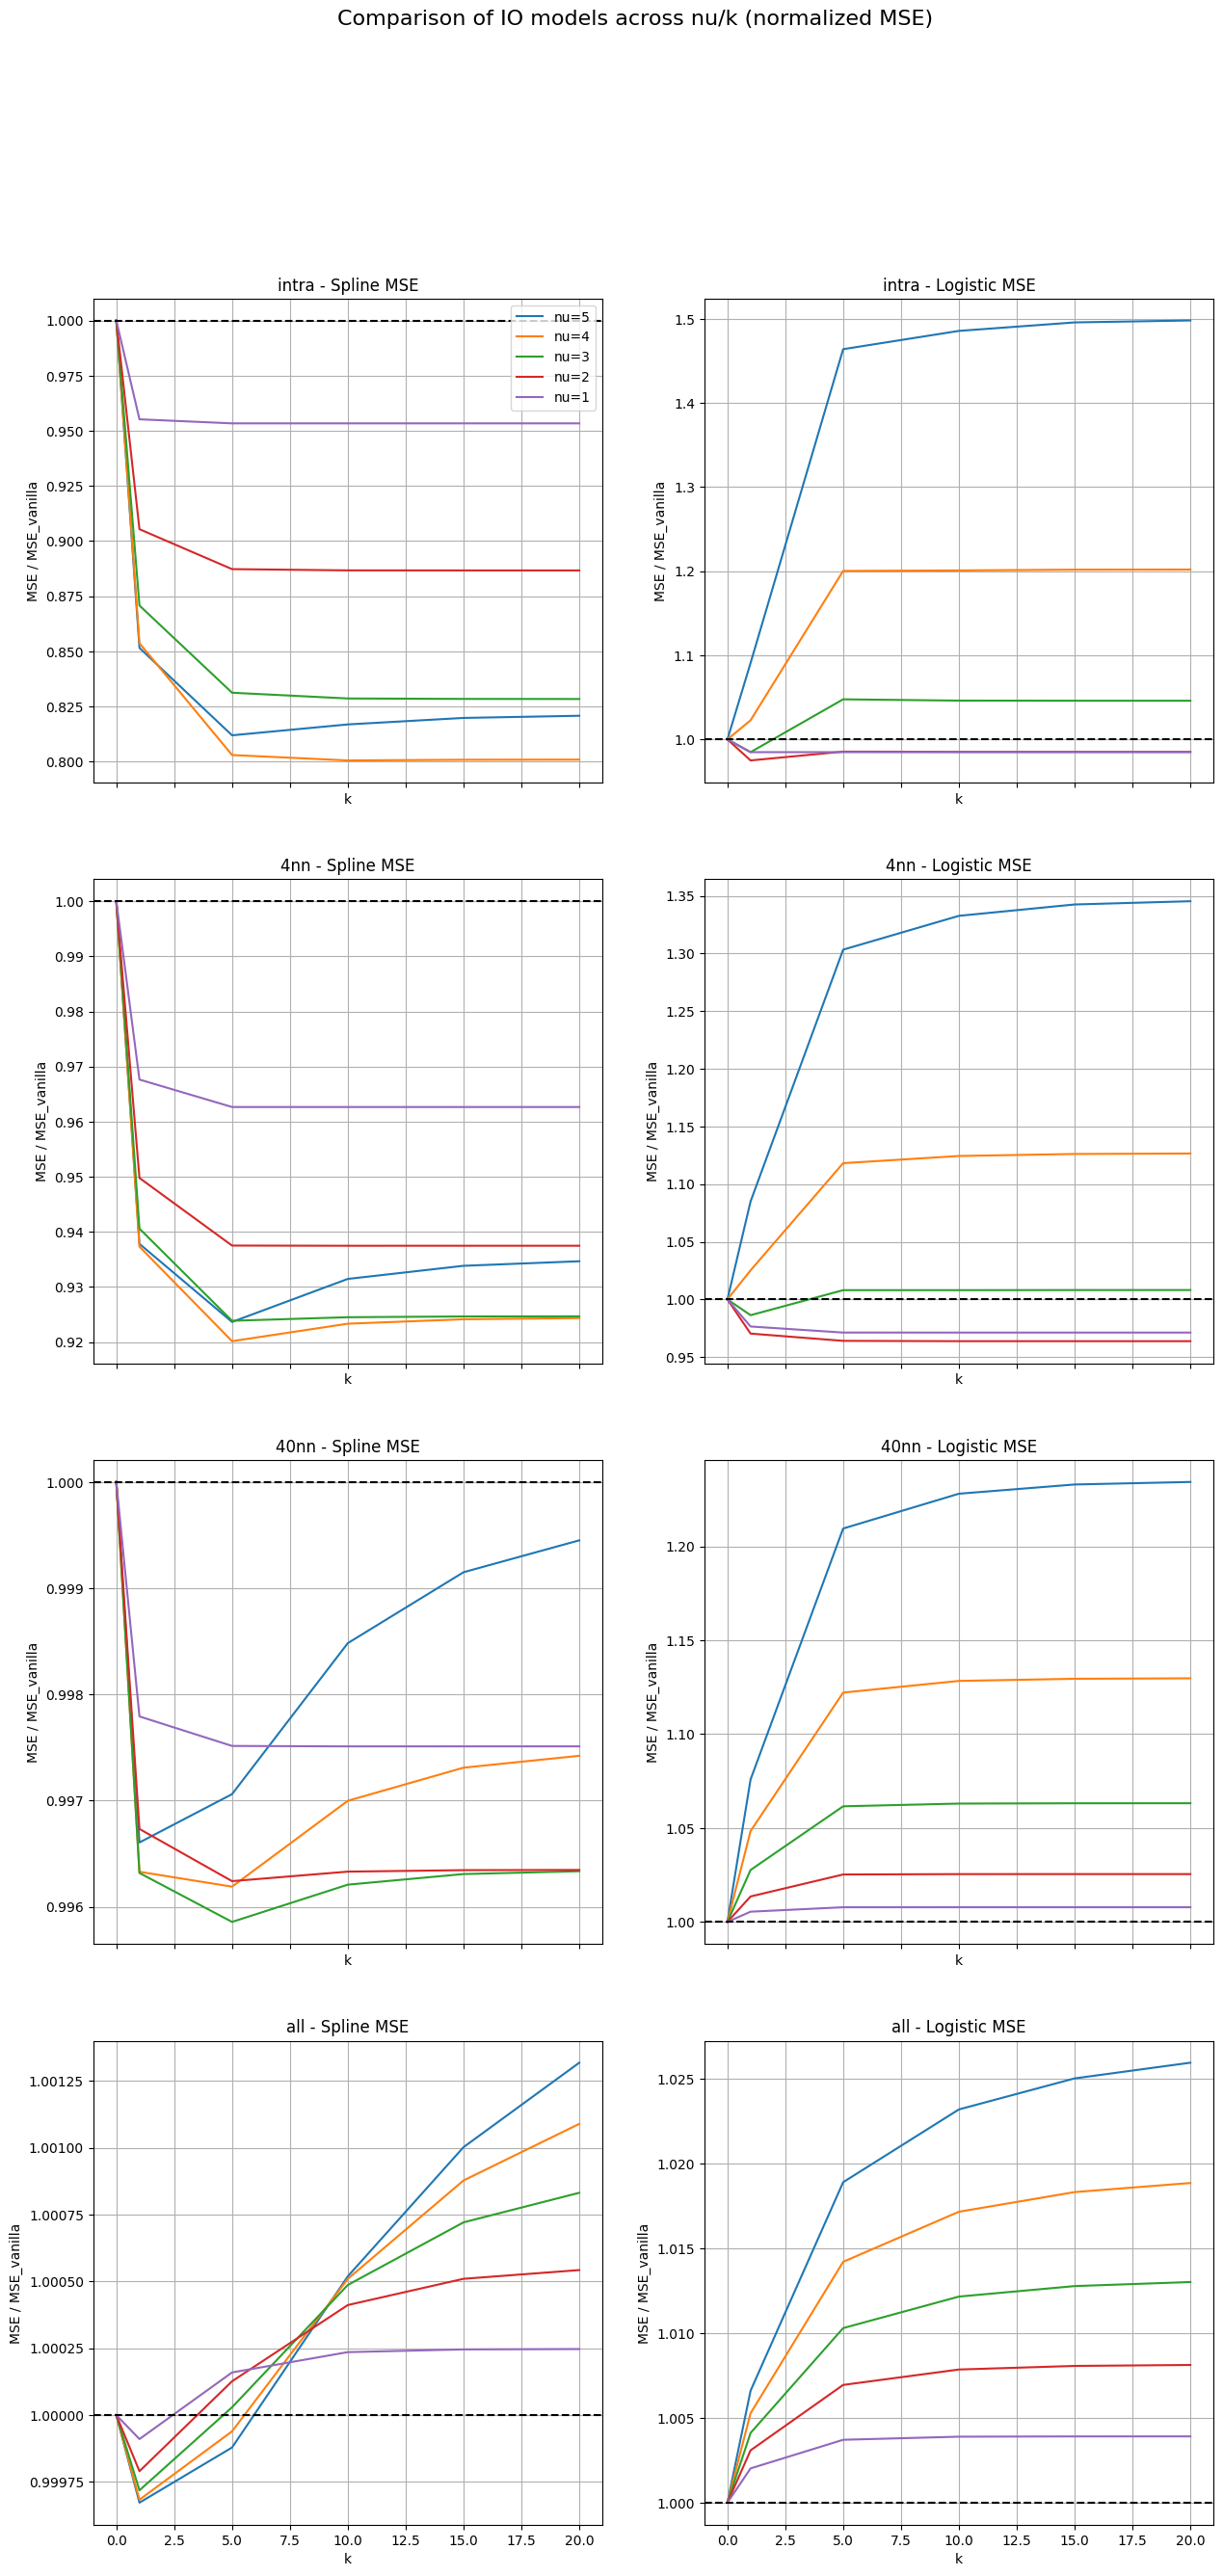

In [ ]:
pair_sets = ['intra', '4nn', '40nn','all']
dist_type = 'geo'  # ou 'ari', 'har'

nu_values = [7, 5, 4, 3, 2, 1]
colors = plt.cm.tab10.colors[:len(nu_list)]

fig, axes = plt.subplots(4, 2, figsize=(15, 30), sharex=True)


for i, pair in enumerate(pair_sets):
    ax1 = axes[i, 0]  # spline
    ax2 = axes[i, 1]  # logistique
    #ax3 = axes[i, 2]  # logistique carré

    mse_vanilla_ols = df_ols_mse.loc[('nu=1', 'k=0'), (pair, dist_type)]
    mse_vanilla_log = df_logistic_mse.loc[('nu=1', 'k=0'), (pair, dist_type)]


    for j, nu in enumerate(nu_list):
        mse_vals_ols = []
        mse_vals_log = []
        #mse_vals_log_sq = []
        k_vals = []

        for k in k_list:
            idx = (f'nu={nu}', f'k={k}')
            k_vals.append(k)
            #print(f"MSE vanilla ({pair}, {dist_type}): {mse_vanilla_ols}, {mse_vanilla_log}")



            #mse_vanilla_log_sq = df_logistic_mse_squared.loc[('nu=1', f'k=0'), (pair, dist_type)]

            # Normalize
            mse_ols = df_ols_mse.loc[idx, (pair, dist_type)] / mse_vanilla_ols
            mse_log = df_logistic_mse.loc[idx, (pair, dist_type)]/ mse_vanilla_log
            #mse_log_sq = df_logistic_mse_squared.loc[idx, (pair, dist_type)] / mse_vanilla_log_sq
            #print(f"MSE ({pair}, {dist_type}): {mse_ols}, {mse_log}")

            mse_vals_ols.append(mse_ols)
            mse_vals_log.append(mse_log)
            #mse_vals_log_sq.append(mse_log_sq)

        ax1.plot(k_vals, mse_vals_ols, label=f'nu={nu}', color=colors[j], linestyle='-')
        ax2.plot(k_vals, mse_vals_log, label=f'nu={nu}', color=colors[j], linestyle='-')
        #ax3.plot(k_vals, mse_vals_log_sq, label=f'nu={nu}', color=colors[j], linestyle='-.')

    ax1.set_title(f"{pair} - Spline MSE")
    ax2.set_title(f"{pair} - Logistic MSE")
    #ax3.set_title(f"(g{i+1}) {pair} - Logistic Squared MSE")


    #ax1.set_ylim(0.999, 1.001)
    #ax2.set_ylim(0.999, 1.001)
    ax1.axhline(y = 1, color='black', linestyle='--')
    ax2.axhline(y = 1, color='black', linestyle='--')
    ax1.set_ylabel("MSE / MSE_vanilla")
    ax2.set_ylabel("MSE / MSE_vanilla")
    ax1.set_xlabel("k")
    ax2.set_xlabel("k")
    ax1.grid(True)
    ax2.grid(True)


# Légende
axes[0,0].legend(loc='upper right', fontsize=10)
plt.suptitle("Comparison of IO models across nu/k (normalized MSE)", fontsize=16)
plt.show()



In [ ]:
Mse_distance = {}
Mse_distance_log = {}

for pair_group, pairs in pairs_dict.items():
    try:
        # Données
        x = get_row_col_pairs_from_df(distance, pairs).values
        y = Y_values[pair_group]

        if len(x) < 10:
            continue

        # Tri
        idx = np.argsort(x)
        x_sorted = x[idx]
        y_sorted = y[idx]

        # ---- Spline (OLS sur log(y)) ----
        log_y = np.log(y_sorted)
        sigma = 1 / x_sorted
        knots = np.round(np.linspace(0, len(x)-1, 10)).astype(int)
        X = get_X(1 / x_sorted, knots, add_const=True)

        model = sm.OLS(log_y, X, hasconst=True)
        results = model.fit()
        mse_ols_distance = results.mse_resid
        Mse_distance[pair_group] = mse_ols_distance

        # ---- Logistic ----
        xdata = np.log(x_sorted)
        cond, popt, mse_logistic, _ = eval_curve_fit(xdata, y_sorted, sigma=sigma)
        if cond:
            Mse_distance_log[pair_group] = mse_logistic

    except Exception as e:
        print(f"Erreur distance-only ({pair_group}) : {e}")
        continue

print('End distance-only;  Start best params search')

Ratios IO/Distance (OLS spline):
{'intra': np.float64(0.25400651729538604), '4nn': np.float64(0.6249636941011971), '40nn': np.float64(0.8355950292541711), 'all': np.float64(1.052648357720816)}


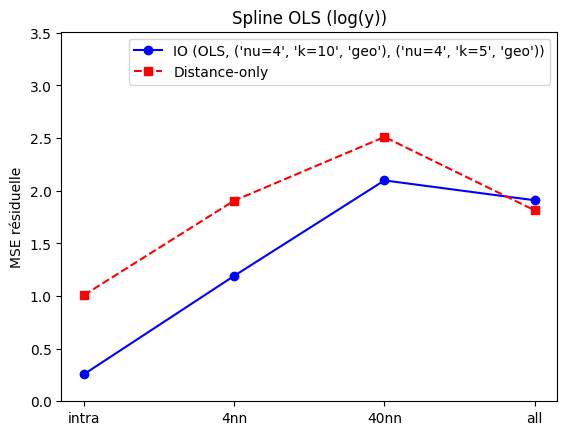

In [ ]:
# Construire dictionnaires de MSE IO
best_io_ols_params = df_ols_mse.stack(future_stack=True).idxmin()
nu_star, k_star, _, dist_type = best_io_ols_params   # Keep key as string

best_io_log_params = df_logistic_mse.stack(future_stack=True).idxmin()
nu_star_log, k_star_log, _, dist_type_log = best_io_log_params
Mse_io = {}
Mse_io_log = {}

for pair in pair_sets:
    nu_k, dist_type = best_io_ols_params[pair][:2], best_io_ols_params[pair][2]
    Mse_io[pair] = df_ols_mse.loc[nu_k, (pair, dist_type)]

    nu_k_log, dist_type_log = best_io_log_params[pair][:2], best_io_log_params[pair][2]
    Mse_io_log[pair] = df_logistic_mse.loc[nu_k_log, (pair, dist_type_log)]

#Ratio Comparison
ratios_ols = {pair: Mse_io[pair] / Mse_distance[pair] for pair in pair_sets if pair in Mse_distance}
ratios_log = {pair: Mse_io_log[pair] / Mse_distance_log[pair] for pair in pair_sets if pair in Mse_distance_log}

print("Ratios IO/Distance (OLS spline):")
print(ratios_ols)


#Plot IO v. Distance
plt.figsize=(10, 10)

axe_x = np.arange(len(pair_sets))
# --- OLS spline ---
plt.plot(axe_x, [Mse_io[p] for p in pair_sets], color='blue', marker='o', label=f'IO (OLS, {nu_star}, {k_star})')
plt.plot(axe_x, [Mse_distance[p] for p in pair_sets], color='red', linestyle='--', marker='s', label='Distance-only')
plt.ylim([0,max(max([Mse_io[p] for p in pair_sets]), max([Mse_distance[p] for p in pair_sets]))+1])
plt.xticks(axe_x,pair_sets)
plt.title("Spline OLS (log(y))")
plt.ylabel("MSE résiduelle")
plt.legend()
plt.show()


In [ ]:
# Find the optimal nu and k for OLS model
min_ols_mse = df_ols_mse[('4nn', 'geo')].min()
optimal_ols_params = df_ols_mse[('4nn', 'geo')][df_ols_mse[('4nn', 'geo')] == min_ols_mse].index[0]
optimal_ols_nu = int(optimal_ols_params[0].split('=')[1])
optimal_ols_k = int(optimal_ols_params[1].split('=')[1])

print(f"Optimal parameters for OLS ('4nn', 'geo'): nu={optimal_ols_nu}, k={optimal_ols_k} (MSE={min_ols_mse:.4f})")

# Find the optimal nu and k for Logistic model
min_logistic_mse = df_logistic_mse[('4nn', 'geo')].min()
optimal_logistic_params = df_logistic_mse[('4nn', 'geo')][df_logistic_mse[('4nn', 'geo')] == min_logistic_mse].index[0]
optimal_logistic_nu = int(optimal_logistic_params[0].split('=')[1])
optimal_logistic_k = int(optimal_logistic_params[1].split('=')[1])
print(f"Optimal parameters for Logistic ('all', 'geo'): nu={optimal_logistic_nu}, k={optimal_logistic_k} (MSE={min_logistic_mse:.4f})")

# Find the optimal nu and k for Log Squared model
#min_logistic_mse_sq = df_logistic_mse_squared[('4nn', 'geo')].min()
#optimal_logistic_params_sq = df_logistic_mse_squared[('4nn', 'geo')][df_logistic_mse_squared[('4nn', 'geo')] == min_logistic_mse_sq].index[0]
#optimal_logistic_nu_sq = int(optimal_logistic_params_sq[0].split('=')[1])
#optimal_logistic_k_sq = int(optimal_logistic_params_sq[1].split('=')[1])
#print(f"Optimal parameters for Logistic Squared ('all', 'geo'): nu={optimal_logistic_nu_sq}, k={optimal_logistic_k_sq} (MSE={min_logistic_mse_sq:.4f})")

optimal_rank_dist_non_sym_ols = get_fuzzy_kotsubo_exp(pop, distance, nu=optimal_ols_nu, k=optimal_ols_k, minus=False)
optimal_rank_dist_geo_ols = (optimal_rank_dist_non_sym_ols * optimal_rank_dist_non_sym_ols.T)**0.5
rd_geo_flat_ols = optimal_rank_dist_geo_ols.values[np.tril_indices_from(optimal_rank_dist_geo_ols, k=0)]

optimal_rank_dist_non_sym_log = get_fuzzy_kotsubo_exp(pop, distance, nu=optimal_logistic_nu, k=optimal_logistic_k, minus=False)
optimal_rank_dist_geo_log = (optimal_rank_dist_non_sym_log * optimal_rank_dist_non_sym_log.T)**0.5
rd_geo_flat_log = optimal_rank_dist_geo_log.values[np.tril_indices_from(optimal_rank_dist_geo_log, k=0)]

#optimal_rank_dist_non_sym_log_sq = get_fuzzy_kotsubo_exp(pop, distance, nu=optimal_logistic_nu_sq, k=optimal_logistic_k_sq, minus=False)
#optimal_rank_dist_geo_log_sq = (optimal_rank_dist_non_sym_log_sq * optimal_rank_dist_non_sym_log_sq.T)**0.5
#rd_geo_flat_log_sq = optimal_rank_dist_geo_log_sq.values[np.tril_indices_from(optimal_rank_dist_geo_log_sq, k=0)]

sci_values = SCI_hat_matrix.values[np.tril_indices_from(SCI_hat_matrix, k=0)]

valid_mask = (~np.isnan(sci_values))

x_ols = rd_geo_flat_ols[valid_mask]
x_log = rd_geo_flat_log[valid_mask]
#x_log_sq = rd_geo_flat_log_sq[valid_mask]
y = sci_values[valid_mask]

log_y = np.log(y)
sigma = 1 / x_log
knots = np.round(np.linspace(0, len(x_ols) - 1, 10)).astype(int)
X_ols = get_X(1 / x_ols, knots, add_const=True)
model_ols = sm.OLS(log_y, X_ols, hasconst=True)
results_ols = model_ols.fit()


predicted_log_sci_ols = results_ols.predict(X_ols)
resid_log_sci_ols = results_ols.resid
exog_log_sci_ols = results_ols.model.exog
predicted_sci_ols = np.exp(predicted_log_sci_ols)

xdata = np.log1p(x_log)
#cond, popt_logistic, mse_logistic = eval_curve_fit(xdata, y, sigma=sigma)
#

#
#xdata_sq = np.log1p(x_log_sq)
#cond_sq, popt_logistic_sq, mse_logistic_sq = eval_curve_fit(xdata_sq, y, sigma=sigma)
#predicted_sci_logistic_sq = gen_log(xdata_sq, *popt_logistic_sq)


#plt.figure(figsize=(10, 7))
#
#plt.scatter(x[np.argsort(x)], predicted_sci_ols[np.argsort(x)], color='blue', label='OLS Predicted SCI')
#plt.scatter(x, y, color='darkorange', alpha=1, s=5, label='Actual SCI')
#
#
#plt.plot(x[np.argsort(x)], predicted_sci_logistic[np.argsort(x)], color='blue', label='Logistic Predicted SCI')
#
##plt.plot(x[np.argsort(x)], predicted_sci_logistic_sq[np.argsort(x)], color='green', label='Logistic Squared Predicted SCI')
#
#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel("IO (Intervening Opportunities)", fontsize=12)
#plt.ylabel("SCI (Social Connectedness Index)", fontsize=12)
#plt.title(f"Actual vs. Predicted SCI for OLS and Logistic Models\n(nu={1}, k={1}, rank=geo, all pairs)", fontsize=14)
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()

Optimal parameters for OLS ('4nn', 'geo'): nu=5, k=5 (MSE=1.1956)
Optimal parameters for Logistic ('all', 'geo'): nu=2, k=10 (MSE=5948.7520)


In [ ]:

test = het_breuschpagan(resid_log_sci_ols, exog_log_sci_ols)
labels = ['LM stat', 'LM p-value', 'F stat', 'F p-value']
print(dict(zip(labels, test)))


{'LM stat': np.float64(11292.785895178757), 'LM p-value': np.float64(0.0), 'F stat': np.float64(1145.2881445714945), 'F p-value': np.float64(0.0)}


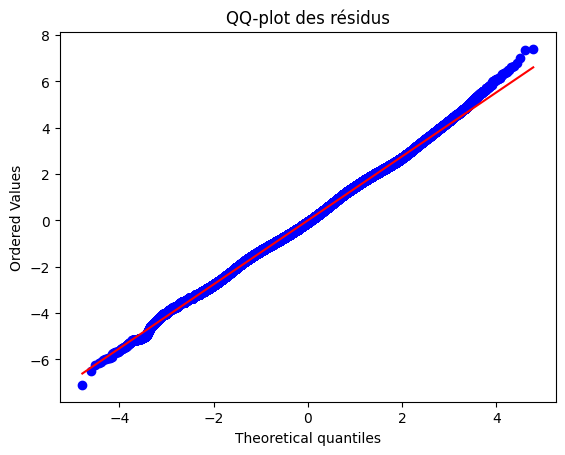

In [ ]:
stats.probplot(resid_log_sci_ols, dist="norm", plot=plt)
plt.title("QQ-plot des résidus")
plt.show()